# Policy analysis
The point of this notebook is to analyze the privacy policies fetched with the spider.  
This presumes all the policies that are marked as successfully gathered in the report file are good, and only looks at said policies

In [2]:
import os
import json
import justext
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import langid
    
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.cluster import DBSCAN

In [3]:
def site_name_from_file_name(file_name):
    return file_name[len("policy_"):len(file_name) - 4]

In [4]:
def make_policy_files():
    policy_files = []
    for filename in policy_file_names:
        policy_files.append(open(DATADIR + filename))
    return policy_files

## 1 Overview

In [5]:
DATADIR = "data/"
POLICY_FILE_PREFIX = "policy_"
REPORT_FILE_NAME = "crawl_report.json"

In [6]:
report_json = pd.read_json(DATADIR + REPORT_FILE_NAME)
report_json

,url,policy_domain,policy_url,policy_file,uses_iubenda,success,ignore
0,https://www.wikipedia.org/,meta.wikimedia.org,https://meta.wikimedia.org/wiki/Privacy_policy,policy_www.wikipedia.org.txt,False,True,False
1,https://www.google.com/,www.google.com,https://www.google.com/intl/it/policies/privacy/,policy_www.google.com.txt,False,True,False
2,https://twitter.com,twitter.com,https://twitter.com/privacy,policy_twitter.com.txt,False,True,False
3,https://www.youtube.com/,www.youtube.com,https://www.youtube.com/t/privacy,policy_www.youtube.com.txt,False,True,False
4,https://outlook.live.com/owa/,go.microsoft.com,https://go.microsoft.com/fwlink/?LinkId=521839,policy_outlook.live.com.txt,False,True,False
...,...,...,...,...,...,...,...
350,https://www.americanexpress.com/it-it/,www.americanexpress.com,https://www.americanexpress.com/it-it/chi-siam...,policy_www.americanexpress.com.txt,False,True,False
351,https://www.fedex.com/,None,None,policy_www.fedex.com.txt,False,False,False
352,https://www.oreilly.com/,www.oreilly.com,https://www.oreilly.com/privacy.html,policy_www.oreilly.com.txt,False,True,False
353,https://uci.edu,uci.edu,https://uci.edu/privacy/index.php,policy_uci.edu.txt,False,True,False


### 1.1 Success rate

In [7]:
# Recap
number_total = len(report_json)
print("Analyzed sites: " + str(number_total))

successful = report_json.loc[report_json["success"] == True]
number_successful = len(successful)
print("Successfully downloaded: " + str(number_successful))

print("Success rate: " + str(round((100 * number_successful / number_total), 1)) + "%")

failed_with_url = report_json.loc[pd.notna(report_json["policy_url"])
                                  & (report_json["success"] == False)]
print("Policy url found but no good policy found: " + str(len(failed_with_url)))
failed_with_url

Analyzed sites: 355
Successfully downloaded: 253
Success rate: 71.3%
Policy url found but no good policy found: 24


,url,policy_domain,policy_url,policy_file,uses_iubenda,success,ignore
14,https://consent.yahoo.com/v2/collectConsent?se...,consent.yahoo.com,https://consent.yahoo.com/redirect?to=https%3A...,policy_consent.yahoo.com.txt,False,False,False
29,https://www.tumblr.com/explore/trending?source...,www.tumblr.com,https://www.tumblr.com/policy/privacy,policy_www.tumblr.com.txt,False,False,False
33,https://www.paypal.com/it/home,www.paypal.com,https://www.paypal.com/privacy-center,policy_www.paypal.com.txt,False,False,False
45,https://edition.cnn.com/,edition.cnn.com,https://edition.cnn.com/privacy,policy_edition.cnn.com.txt,False,False,False
51,https://www.ebay.com/,www.ebay.com,https://www.ebay.com/help/policies/default/eba...,policy_www.ebay.com.txt,False,False,False
54,https://www.bbc.com/,www.bbc.co.uk,https://www.bbc.co.uk/usingthebbc/privacy/,policy_www.bbc.com.txt,False,False,False
56,https://www.bbc.co.uk/,www.bbc.co.uk,https://www.bbc.co.uk/usingthebbc/privacy,policy_www.bbc.co.uk.txt,False,False,False
57,https://it.aliexpress.com/?gatewayAdapt=glo2ita,sale.aliexpress.com,https://sale.aliexpress.com/pp-setting.htm,policy_it.aliexpress.com.txt,False,False,False
92,https://www.springer.com/it,www.springer.com,https://www.springer.com/it/editorial-policies,policy_www.springer.com.txt,False,False,False
94,https://www.php.net/,www.php.net,https://www.php.net/manual/en/features.cookies...,policy_www.php.net.txt,False,False,False


### 1.2 Sites overview

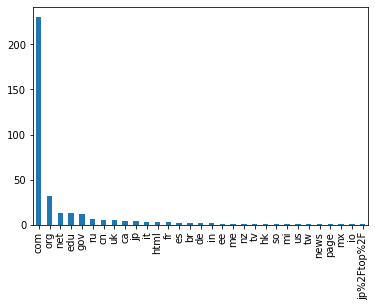

In [8]:
# TLDs

urls = report_json["url"]
ul = urls.tolist()

tlds = {}
for url in ul:
    tld = ((url.split(".")[len(url.split(".")) - 1]).split("/")[0]).split(":")[0]
    if tld in tlds.keys():
        tlds[tld] = tlds[tld] + 1
    else:
        tlds[tld] = 1
        
pd.Series(tlds).sort_values(ascending = False).plot.bar()
plt.show()

## 2 Simple analysis

In [9]:
# Open policy files
policy_file_names = successful["policy_file"].tolist()

### 2.1 Language detection

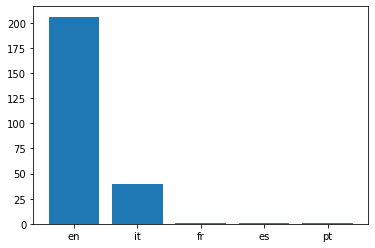

In [10]:
# Language detection
policy_files = []
for filename in policy_file_names:
    policy_files.append(open(DATADIR + filename))


languages = {}
for file in policy_files:
    languages[file.name] = langid.classify(file.read())[0]

plt.bar(pd.Series(languages).value_counts().keys(), pd.Series(languages).value_counts())
plt.show()

### 2.2 Detecting suspicious entries with DBSCAN
Some bad text will make it through the spider. With some clustering we can find suspicious texts and weed them out manually.  
Language detection is done before this in order to do clustering separately for each detected language.  
This step also detects policies from the same company on different sites i.e. wikimedia.org and wikipedia.org quite well.


Current language: en
Found 7 clusters
Labels: 
[ 0  1  2  3  1  1  1  1  1  1  1  1  1  2  1  1  1  1  1  1  1  1  1  3
  1  1  1  1  1 -1  1 -1  1  1  1  1  1  1  4  1  1  0  1 -1  1  1  1  2
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
 -1  1  5  1  1  1  1  1  1  1  1  1  1  4  1  1  1  1  1  1  1  1  1  1
  1  1  2  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  5  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  5  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  0  1  1  1  1  1  1  1]

Cluster: -1 with 4 elements
data/policy_www.w3.org.txt       W3C Standards Participate Membership About W3C...
data/policy_www.etsy.com.txt     Etsy Search for items or shops Skip to Content...
data/policy_www.opera.com.txt    La pagina richiesta non è ancora disponibile n...
data/policy_www.npr.org.txt      Accessibility

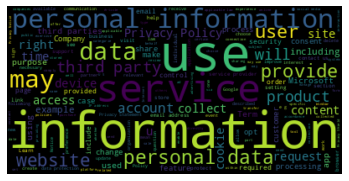


Cluster: 0 with 3 elements
data/policy_www.wikipedia.org.txt     Privacy policy From Meta, a Wikimedia project ...
data/policy_www.wikimedia.org.txt     Privacy policy From Meta, a Wikimedia project ...
data/policy_www.wiktionary.org.txt    Privacy policy From Meta, a Wikimedia project ...
Name: Text, dtype: object


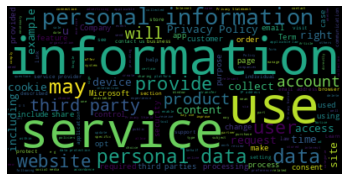


Cluster: 1 with 188 elements
data/policy_twitter.com.txt            Skip to main content Privacy Policy Twitter Pr...
data/policy_wordpress.org.txt          Skip to content Log In Register WordPress.org ...
data/policy_www.apple.com.txt          Global Nav Open MenuGlobal Nav Close Menu Appl...
data/policy_www.amazon.com.txt         Skip to main content .us Deliver to\nItaly All...
data/policy_vimeo.com.txt              Contact Sales Upload Create video Record scree...
                                                             ...                        
data/policy_www.newyorker.com.txt      Skip to main content About Brands Stores Comme...
data/policy_www.irs.gov.txt            Skip to main content An official website of th...
data/policy_www.frontiersin.org.txt    Skip to main content Navigation Top bar naviga...
data/policy_www.oreilly.com.txt        Skip to main content Sign In Try Now Teams For...
data/policy_uci.edu.txt                Skip to main content UCI homepage About A

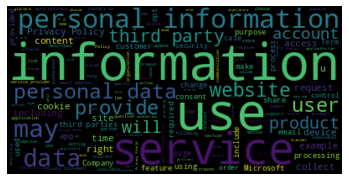


Cluster: 2 with 4 elements
data/policy_outlook.live.com.txt        Skip to main content Microsoft Privacy Privacy...
data/policy_www.msn.com.txt             Skip to main content Microsoft Privacy Privacy...
data/policy_dotnet.microsoft.com.txt    Skip to main content Microsoft Privacy Privacy...
data/policy_azure.microsoft.com.txt     Skip to main content Microsoft Privacy Privacy...
Name: Text, dtype: object


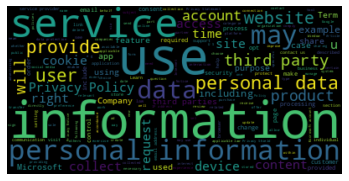


Cluster: 3 with 2 elements
data/policy_github.com.txt          Skip to main content GitHub Docs All products ...
data/policy_pages.github.com.txt    Skip to main content GitHub Docs All products ...
Name: Text, dtype: object


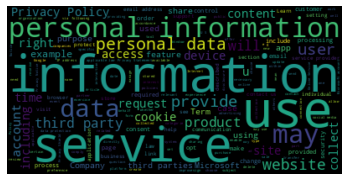


Cluster: 4 with 2 elements
data/policy_www.oracle.com.txt    Click to view our Accessibility Policy Skip to...
data/policy_www.mysql.com.txt     Click to view our Accessibility Policy Skip to...
Name: Text, dtype: object


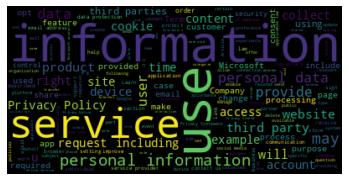


Cluster: 5 with 3 elements
data/policy_www.espn.com.txt                  Skip to contentSkip to navigation Country/Regi...
data/policy_www.nationalgeographic.com.txt    Skip to contentSkip to navigation Country/Regi...
data/policy_www.hulu.com.txt                  Skip to contentSkip to navigation Country/Regi...
Name: Text, dtype: object


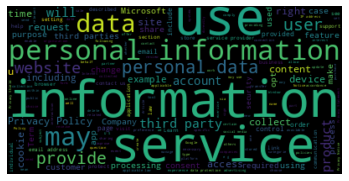


Current language: it
Found 5 clusters
Labels: 
[ 0  0  1  2  1  3 -1  0  0  1  0  3  0 -1  0  3  3  0  3  2  3  3  3  0
  3  0  0  3  0  1 -1  0  0  3  3  3  3  0  0 -1]

Cluster: -1 with 4 elements
data/policy_www.mozilla.org.txt            Scarica Firefox\nInformativa sulla privacy di ...
data/policy_www.samsung.com.txt            Skip to contentSkip to accessibility help Sams...
data/policy_www.nvidia.com.txt             NVIDIA HomeNVIDIA HomeMenuMenu iconMenuMenu ic...
data/policy_www.americanexpress.com.txt    Skip to content MenuMenu Il seguente elemento ...
Name: Text, dtype: object


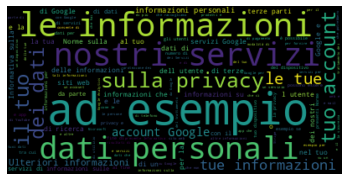


Cluster: 0 with 16 elements
data/policy_www.google.com.txt       Privacy e termini Accedi Introduzione Norme su...
data/policy_www.youtube.com.txt      Privacy e termini Accedi Introduzione Norme su...
data/policy_www.blogger.com.txt      Privacy e termini Privacy e termini Accedi Int...
data/policy_www.google.com.hk.txt    Privacy e termini Privacy e termini Accedi Int...
data/policy_www.google.co.in.txt     Privacy e termini Privacy e termini Accedi Int...
data/policy_www.google.co.uk.txt     Privacy e termini Privacy e termini Accedi Int...
data/policy_www.google.de.txt        Privacy e termini Privacy e termini Accedi Int...
data/policy_www.google.co.jp.txt     Privacy e termini Privacy e termini Accedi Int...
data/policy_www.google.ru.txt        Privacy e termini Privacy e termini Accedi Int...
data/policy_www.google.ca.txt        Privacy e termini Privacy e termini Accedi Int...
data/policy_www.google.fr.txt        Privacy e termini Privacy e termini Accedi Int...
data/policy_ww

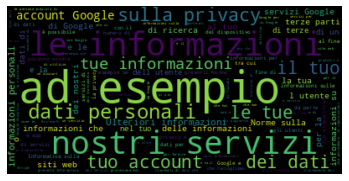


Cluster: 1 with 4 elements
data/policy_www.microsoft.com.txt             Passa a contenuti principali Microsoft Privacy...
data/policy_www.office.com.txt                Passa a contenuti principali Microsoft Privacy...
data/policy_www.skype.com.txt                 Passa a contenuti principali Microsoft Privacy...
data/policy_visualstudio.microsoft.com.txt    Passa a contenuti principali Microsoft Privacy...
Name: Text, dtype: object


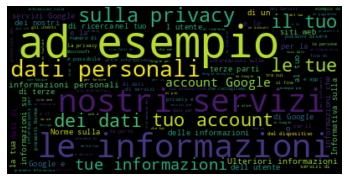


Cluster: 2 with 2 elements
data/policy_www.whatsapp.com.txt    WHATSAPP WEB FUNZIONI SCARICA PRIVACY CENTRO A...
data/policy_stripe.com.txt          Stripe logo Stripe Services Agreement Stripe C...
Name: Text, dtype: object


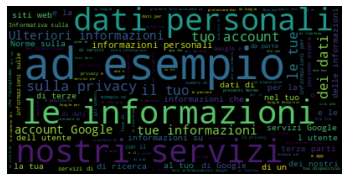


Cluster: 3 with 14 elements
data/policy_zoom.us.txt                Assistenza 1.888.799.9666 Chiedi una dimostraz...
data/policy_www.salesforce.com.txt     Passa direttamente al contenuto CHI SIAMO Chi ...
data/policy_www.eventbrite.com.txt     Skip Main Navigation Eventbrite\nCentro di Ass...
data/policy_www.godaddy.com.txt        Nomi di dominio Cerca i nomi di dominio Trasfe...
data/policy_mailchimp.com.txt          Passa al contenuto principale Ricerca Prova a ...
data/policy_www.zendesk.com.txt        Accedi Assistenza prodotto Azienda Chi siamo S...
data/policy_weather.com.txt            Passa al contenuto principaleAssistenza per ac...
data/policy_it.squarespace.com.txt     Passa al contenuto principale Squarespace Logo...
data/policy_www.amazon.it.txt          Continua senza accettare Selezione delle prefe...
data/policy_www.change.org.txt         Lancia una petizione Le mie petizioni Sfoglia ...
data/policy_www.vice.com.txt           VICE INFORMATIVA SULLA PRIVACY DI VICE MED

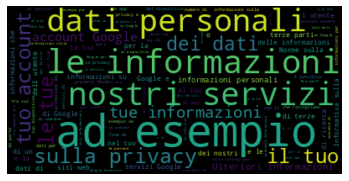


Current language: fr
Sample size for  too small

Current language: es
Sample size for  too small

Current language: pt
Sample size for  too small


In [13]:
# core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
# core_samples_mask[db.core_sample_indices_] = True

# # n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

langs = pd.Series(languages).unique()

for lang in langs:
    language = ""
    
    if lang == "it":
        language = "italian"
    elif lang == "en":
        language = "english"
#     else:
#         break
        
    print("\nCurrent language: " + lang)

    vectorizer = TfidfVectorizer(
        max_df=0.5,
        min_df=5,
    )


    texts_in_lang = []
    
    df_texts_in_lang = pd.DataFrame(columns = ["Text"])

    for file in make_policy_files():
        file_text = file.read()
        file_lang = langid.classify(file_text)[0]
        if file_lang == lang:
            texts_in_lang.append(file_text)
            df_texts_in_lang.loc[file.name] = file_text
            
    if len(texts_in_lang) < 10: # Ignore small sample sizes
        print("Sample size for " + language + " too small")
        continue

    # --

    X_tfidf = vectorizer.fit_transform(df_texts_in_lang.Text)
    
    lsa = make_pipeline(TruncatedSVD(n_components=100), Normalizer(copy=False))

    X_lsa = lsa.fit_transform(X_tfidf)
    explained_variance = lsa[0].explained_variance_ratio_.sum()

    X = X_lsa

    # eps=1.30 works well
    # 1.20 is where it starts to make to many clusters with just one element
    # 1.25 with min_samples=2 has a reasonable amount of outliers
    
    custom_eps = 1.25
    
#     db = DBSCAN(eps=custom_eps, min_samples=len(df_texts_in_lang) // 10).fit(X) # each cluster must contain at lesast 1/10th of the total
#     db = DBSCAN(eps=custom_eps, min_samples=1).fit(X)
    db = DBSCAN(eps=custom_eps, min_samples=2).fit(X) # Avoid singletons

    print("Found " +  str(len(np.unique(db.labels_))) + " clusters")
    print("Labels: \n" + str(db.labels_))
    
    db_df = pd.DataFrame(data = {"Cluster" : db.labels_,
                                 "Text" : df_texts_in_lang.Text},
    #                              "Filename" : df_texts_in_lang.index},
                         index = df_texts_in_lang.index)
    db_df

    dissimilar_entries_urls = db_df.loc[db_df["Cluster"] != 0].index.tolist()
#     print(dissimilar_entries_urls) # Dissimilar entries
#     print(db_df.loc[db_df["Cluster"] == 0])

    # Print out each cluster
    for cluster in np.unique(db.labels_):
        cluster_content = db_df.loc[db_df["Cluster"] == cluster]["Text"]
        cluster_size = len(cluster_content)
        
        print("\nCluster: " + str(cluster) + " with " + str(cluster_size) + " elements")
        print(cluster_content)
        
        # Make wordclouds for each cluster?        
        all_policy_text = ""
        for policy_text in df_texts_in_lang["Text"]:
            all_policy_text += policy_text

        wordcloud = WordCloud().generate(all_policy_text)

        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.show()


#     print("Found " + str(len(dissimilar_entries_urls)) + " dissimilar entries")

In [44]:
# db_df = pd.DataFrame(data = {"Cluster" : db.labels_,
#                              "Text" : df_texts_in_lang.Text},
# #                              "Filename" : df_texts_in_lang.index},
#                      index = df_texts_in_lang.index)
# db_df

In [45]:
# db_df.loc[db_df["Cluster"] == -1] # Dissimilar entries

### 2.3 Wordcounts

en
206 total policies


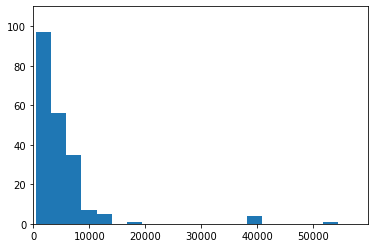

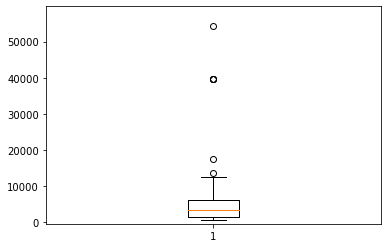

it
40 total policies


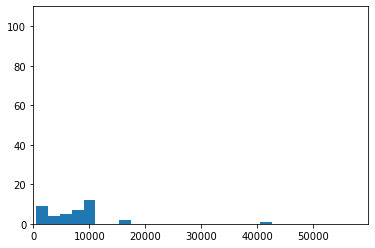

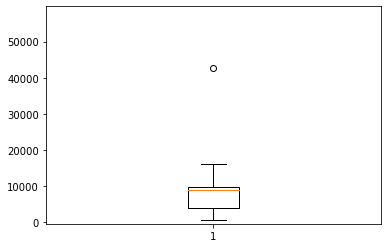

fr
1 total policies
Sample size for fr too small
es
1 total policies
Sample size for es too small
pt
1 total policies
Sample size for pt too small


In [14]:
# Simple analysis i.e. wordcount

policy_files = []
for filename in policy_file_names:
    policy_files.append(open(DATADIR + filename))

highest_wordcount = 0
for file in policy_files:
    file_wordcount = len(file.read().split())
    if file_wordcount > highest_wordcount:
        highest_wordcount = file_wordcount

    
for language in pd.Series(languages).value_counts().keys():
    policy_files = []
    for filename in languages.keys():
        if languages[filename] == language:
            filename = filename[len("data/"):]
            policy_files.append(open(DATADIR + filename))
    
    print(language)
    total_policies_current_language = len(policy_files)
    print(str(total_policies_current_language) + " total policies")
    if total_policies_current_language < 10: # Ignore small sample sizes
        print("Sample size for " + language + " too small")
        continue
    
    wordcounts = []
    for file in policy_files:
        wordcounts.append(len(file.read().split()))

#     plt.ylim(0, 15)
    plt.ylim(0, 110)
    plt.xlim(0, highest_wordcount * 1.1)
    plt.hist(wordcounts, 20)
    plt.show()
    
    plt.ylim(-(highest_wordcount / 100), highest_wordcount * 1.1)
    plt.boxplot(wordcounts)
    plt.show()

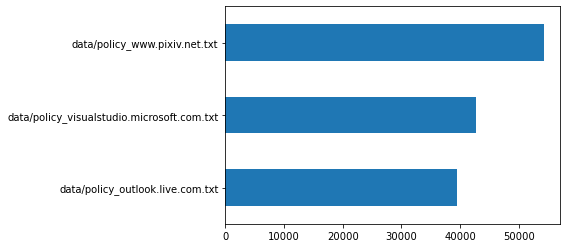

In [15]:
# Top 3 longest policies by wordcount overall

policy_files = []
for filename in policy_file_names:
    policy_files.append(open(DATADIR + filename))

wc_dict = {}

for file in policy_files:
    wc_dict[file.name] = len(file.read().split())
    
wc_s = pd.Series(wc_dict).sort_values(ascending=True)
wc_s[len(wc_s) - 3:].plot.barh()
plt.show()

In [16]:
wc_s[len(wc_s) - 3:]

data/policy_outlook.live.com.txt              39532
data/policy_visualstudio.microsoft.com.txt    42626
data/policy_www.pixiv.net.txt                 54348
dtype: int64

### 2.4 Wordclouds

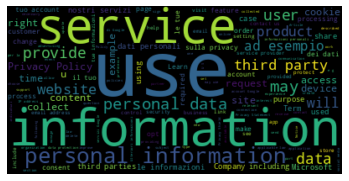

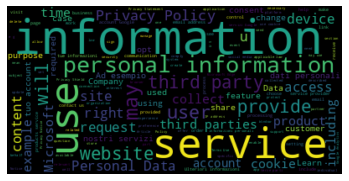

In [17]:
# Some fun wordclouds :)
policy_files = []
for filename in policy_file_names:
    policy_files.append(open(DATADIR + filename))

all_policy_text = ""
for file in policy_files:
    all_policy_text += file.read()

wordcloud = WordCloud().generate(all_policy_text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Unsurprisingly you have to filter out heaps of words...
policy_files = []
for filename in policy_file_names:
    policy_files.append(open(DATADIR + filename))

all_policy_text_filtered = ""
for file in policy_files:
    for word in file.read().split():
        if word not in (justext.get_stoplist("Italian")):
            all_policy_text_filtered += word + " "

wordcloud = WordCloud().generate(all_policy_text_filtered)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### 2.5 Emotion analysis

In [11]:
# # Text2Emotion
# import text2emotion as t2e
# import emoji
# import nltk
# nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /home/user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/user/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/user/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [17]:
# emotions_dict = {
#     "Angry" : 0,
#     "Fear" : 0,
#     "Happy" : 0,
#     "Sad" : 0,
#     "Surprise" : 0
# }

In [18]:
# policy_files = []
# for filename in policy_file_names:
#     policy_files.append(open(DATADIR + filename))

In [18]:
# for file in policy_files:
#     emotions = t2e.get_emotion(file.read())
#     top_emotion = max(emotions)
#     emotions_dict[top_emotion] = emotions_dict[top_emotion] + 1

# emotions_dict

In [19]:
# emotions_dict = {
#     "Angry" : 0,
#     "Fear" : 0,
#     "Happy" : 0,
#     "Sad" : 0,
#     "Surprise" : 0
# }

# policy_files = []
# for filename in policy_file_names:
#     policy_files.append(open(DATADIR + filename))

# for file in policy_files:
#     emotions = t2e.get_emotion(file.read())
#     for emotion in emotions:
#         emotions_dict[emotion] = emotions_dict[emotion] + emotions[emotion] # maybe normalize?

# emotions_dict

In [20]:
# for e in emotions_dict.keys():
#     emotions_dict[e] = round(emotions_dict[e] / len(policy_files), 3)

# emotions_dict

### 2.6 Text clustering

In [164]:
policy_files = []
for filename in policy_file_names:
    policy_files.append(open(DATADIR + filename))

policy_texts = []

for file in policy_files:
    policy_texts.append(file.read())

df = pd.DataFrame(data = policy_texts, columns = ["Text"])
df

,Text
0,Privacy e termini Accedi Introduzione Norme su...
1,Skip to main content Privacy Policy Twitter Pr...
2,Privacy e termini Accedi Introduzione Norme su...
3,Passa a contenuti principali Microsoft Privacy...
4,"Privacy policy From Meta, a Wikimedia project ..."
...,...
275,Skip to main content An official website of th...
276,Privacy e termini Privacy e termini Accedi Int...
277,Skip to content MenuMenu Il seguente elemento ...
278,Skip to main content Sign In Try Now Teams For...


In [165]:
# There should be a separation based on the policy's language

vec = TfidfVectorizer(stop_words = "english", ngram_range = (1, 3))
vec.fit(df.Text.values)
features = vec.transform(df.Text.values)

In [166]:
clust = KMeans(init = "k-means++", n_clusters = 2, n_init = 10)

clust.fit(features)
yhat = clust.predict(features)
df['Cluster Labels'] = clust.labels_

# df.loc[df["Cluster Labels"] == 1]

In [167]:
df_similar = pd.DataFrame(df.loc[df["Cluster Labels"] == 1].values)
# df_similar

In [168]:
df_dissimilar = pd.DataFrame(df.loc[df["Cluster Labels"] == 0].values)
# df_dissimilar

In [169]:
langs = pd.Series(languages).unique()

for lang in langs:
    print(lang)

it
en
zh
qu
la
fr
pt


In [276]:
for lang in langs:
    language = ""
    
    if lang == "it":
        language = "italian"
    elif lang == "en":
        language = "english"
    else:
        break
        
    print("Current language: " + lang)

#     texts_in_lang = {}

    df_texts_in_lang = pd.DataFrame(columns = ["Text"])
    
    for file in make_policy_files():
        file_text = file.read()
        file_lang = langid.classify(file_text)[0]
        if file_lang == lang:
#             texts_in_lang.append(file_text)
#             texts_in_lang[file.name] = file_text
#             print(df_texts_in_lang)
#             df_texts_in_lang = df_texts_in_lang.append([file.name, file_text])
            df_texts_in_lang.loc[file.name] = file_text
    
#     print(texts_in_lang)
    
#     df_texts_in_lang = pd.DataFrame(data = texts_in_lang, columns = ["Filename", "Text"])

    lsa = make_pipeline(TruncatedSVD(n_components=100), Normalizer(copy=False))


    vectorizer = TfidfVectorizer(
        max_df=0.5,
        min_df=5,
#         stop_words="english",
    )

    try:
        X_tfidf = vectorizer.fit_transform(df_texts_in_lang.Text)
    except ValueError:
        continue
    
    X_lsa = lsa.fit_transform(X_tfidf)
    explained_variance = lsa[0].explained_variance_ratio_.sum()


    kmeans = KMeans(
        n_clusters=2,
        max_iter=100,
        n_init=1,
    )

    kmeans.fit(X_lsa)

    original_space_centroids = lsa[0].inverse_transform(kmeans.cluster_centers_)
    order_centroids = original_space_centroids.argsort()[:, ::-1]
    terms = vectorizer.get_feature_names_out()

    for i in range(2):
        print(f"Cluster {i}: ", end="")
        for ind in order_centroids[i, :10]:
            print(f"{terms[ind]} ", end="")
        print()

Current language: it
Cluster 0: youtube risultati gmail esaminare vai android play identificatori chrome inserzionisti 
Cluster 1: microsoft terzi piattaforma to mail social media business proprio and 
Current language: en
Cluster 0: amazon university gov statement microsoft resources wikimedia disney health copyright 
Cluster 1: california shield categories profile ccpa legitimate apps platform uk advertisements 


In [277]:
df_texts_in_lang

,Text
data/policy_twitter.com.txt,Skip to main content Privacy Policy Twitter Pr...
data/policy_www.wikipedia.org.txt,"Privacy policy From Meta, a Wikimedia project ..."
data/policy_outlook.live.com.txt,Skip to main content Microsoft Privacy Privacy...
data/policy_github.com.txt,Skip to main content GitHub Docs All products ...
data/policy_wordpress.org.txt,Skip to content Log In Register WordPress.org ...
...,...
data/policy_wpengine.com.txt,Skip to content WP Engine Products Resources W...
data/policy_www.frontiersin.org.txt,Skip to main content Navigation Top bar naviga...
data/policy_www.irs.gov.txt,Skip to main content An official website of th...
data/policy_www.oreilly.com.txt,Skip to main content Sign In Try Now Teams For...


In [278]:
# df_texts_in_lang["Text"].index[2]

#### DBSCAN

In [297]:
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

vectorizer = TfidfVectorizer(
    max_df=0.5,
    min_df=5,
)


texts_in_lang = []

for file in make_policy_files():
    file_text = file.read()
#     file_lang = langid.classify(file_text)[0]
#     if file_lang == lang:
    texts_in_lang.append(file_text)

# df_texts_in_lang = pd.DataFrame(data = texts_in_lang, columns = ["Text"])

# --

X_tfidf = vectorizer.fit_transform(df_texts_in_lang.Text)

X_lsa = lsa.fit_transform(X_tfidf)
explained_variance = lsa[0].explained_variance_ratio_.sum()

X = X_lsa

db = DBSCAN(eps=1, min_samples=len(df_texts_in_lang) // 10).fit(X) # each cluster must contain at lesast 1/10th of the total
# db.labels_

In [315]:
db_df = pd.DataFrame(data = {"Cluster" : db.labels_,
                             "Text" : df_texts_in_lang.Text},
#                              "Filename" : df_texts_in_lang.index},
                     index = df_texts_in_lang.index)
db_df

,Cluster,Text
data/policy_twitter.com.txt,0,Skip to main content Privacy Policy Twitter Pr...
data/policy_www.wikipedia.org.txt,0,"Privacy policy From Meta, a Wikimedia project ..."
data/policy_outlook.live.com.txt,0,Skip to main content Microsoft Privacy Privacy...
data/policy_github.com.txt,-1,Skip to main content GitHub Docs All products ...
data/policy_wordpress.org.txt,0,Skip to content Log In Register WordPress.org ...
...,...,...
data/policy_wpengine.com.txt,-1,Skip to content WP Engine Products Resources W...
data/policy_www.frontiersin.org.txt,-1,Skip to main content Navigation Top bar naviga...
data/policy_www.irs.gov.txt,-1,Skip to main content An official website of th...
data/policy_www.oreilly.com.txt,0,Skip to main content Sign In Try Now Teams For...


In [319]:
db_df.loc[db_df["Cluster"] == -1] # Dissimilar entries

,Cluster,Text
data/policy_github.com.txt,-1,Skip to main content GitHub Docs All products ...
data/policy_www.apple.com.txt,-1,Global Nav Open MenuGlobal Nav Close Menu Appl...
data/policy_wordpress.com.txt,-1,Automattic Home About Us News Work With Us Pri...
data/policy_bitly.com.txt,-1,Skip Navigation Get the tools to grow with Sta...
data/policy_www.nih.gov.txt,-1,Skip to main content An official website of th...
...,...,...
data/policy_www.ea.com.txt,-1,Electronic Arts Home\nFeatured GamesAll GamesC...
data/policy_www.newyorker.com.txt,-1,Skip to main content About Brands Stores Comme...
data/policy_wpengine.com.txt,-1,Skip to content WP Engine Products Resources W...
data/policy_www.frontiersin.org.txt,-1,Skip to main content Navigation Top bar naviga...


In [300]:
# import matplotlib.pyplot as plt

# # Black removed and is used for noise instead.
# labels = [0, -1]
# unique_labels = set(labels)
# colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

# for k, col in zip(unique_labels, colors):
#     if k == -1:
#         # Black used for noise.
#         col = [0, 0, 0, 1]

#     class_member_mask = labels == k
    
#     xy = X[class_member_mask & core_samples_mask]
#     plt.plot(
#         xy[:, 0],
#         xy[:, 1],
#         "o",
#         markerfacecolor=tuple(col),
#         markeredgecolor="k",
#         markersize=14,
#     )

#     xy = X[class_member_mask & ~core_samples_mask]
#     plt.plot(
#         xy[:, 0],
#         xy[:, 1],
#         "o",
#         markerfacecolor=tuple(col),
#         markeredgecolor="k",
#         markersize=6,
#     )

# plt.title("Estimated number of clusters: %d" % n_clusters_)
# plt.show()

#### 2.6.2 Finer Clustering

In [301]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_sim = cosine_similarity(features)

def getind(c):
    return df[df.Text == c].index.tolist()

def gettext(i):
    return df[df.index == i].Text.tolist()

In [302]:
similar = list(enumerate(cosine_sim[0]))
# similar

In [303]:
# This one kinda does the same thing as the 2 clusters

sim_list = []
unsim_list = []
for m in similar:
    t = gettext(m[0])
    if m[1] > 0.15:
        sim_list.append(t)
    else:
        unsim_list.append(t)

In [304]:
df_sim = pd.DataFrame(sim_list, columns = ["Text"])
df_unsim = pd.DataFrame(unsim_list, columns = ["Text"])

In [305]:
# df_sim

In [306]:
# df_unsim

In [307]:
cosim = list(enumerate(cosine_sim))
cumulative_sim = []

for entry in cosim:
    cumulative_sim.append(0)

for entry in cosim:
    i = 0
    for sim_value in entry[1]:
        cumulative_sim[i] = cumulative_sim[i] + (sim_value / len(cosim)) # Normalization
        
        i = i + 1

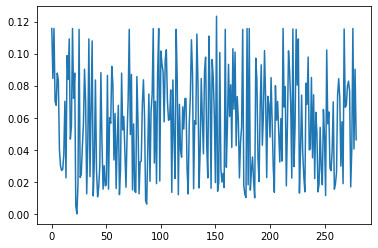

In [308]:
plt.plot(cumulative_sim)

In [309]:
sim_list = []
unsim_list = []

threshold = 0.085

i = 0
for k in cumulative_sim:
    t = gettext(i)
    if k > threshold:
        sim_list.append(t)
    else:
        unsim_list.append(t)
    i = i + 1

In [310]:
df_sim = pd.DataFrame(sim_list, columns = ["Text"])
df_unsim = pd.DataFrame(unsim_list, columns = ["Text"])

In [311]:
# df_sim

In [312]:
# df_unsim

In [313]:
verysim_list = []

threshold = 0.185

i = 0
for k in cumulative_sim:
    t = gettext(i)
    if k > threshold:
        verysim_list.append(t)
#     else:
#         unsim_list.append(t)
    i = i + 1

In [314]:
df_verysim = pd.DataFrame(verysim_list, columns = ["Text"])
df_verysim

,Text
